In [11]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import Phrases
import fasttext
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import sklearn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn import metrics
import json

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

# Обработка данных

In [4]:
train = pd.read_csv('datasets/train.csv', index_col=0)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45398 entries, 12405 to 13043
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   45398 non-null  object
 1   text    45398 non-null  object
 2   from    45398 non-null  object
 3   lemma   45398 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [5]:
test = pd.read_csv('datasets/test.csv', index_col=0)
test = test.dropna()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5960 entries, 14745 to 20671
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5960 non-null   object
 1   text    5960 non-null   object
 2   from    5960 non-null   object
 3   lemma   5960 non-null   object
dtypes: object(4)
memory usage: 232.8+ KB


In [6]:
score_enc = OneHotEncoder(handle_unknown='ignore')
X = test.label.to_numpy().reshape(-1, 1)

unique_items = np.unique(X).reshape(-1, 1)
score_enc.fit(unique_items)

print('Категории:', score_enc.categories_, sep='\n')
print()
for i, desc in zip(score_enc.categories_[0], ['Отрицательные\t', 'Положительные\t']):
    print(desc, i, score_enc.transform(np.array([i]).reshape(-1, 1)).toarray())

Категории:
[array(['negative', 'positive'], dtype=object)]

Отрицательные	 negative [[1. 0.]]
Положительные	 positive [[0. 1.]]


In [7]:
def convert_label(df):
    return score_enc.transform(df.to_numpy().reshape(-1, 1))

In [8]:
X_train = train.lemma.tolist()
y_train = convert_label(train.label)
len(X_train), y_train

(45398,
 <45398x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 45398 stored elements in Compressed Sparse Row format>)

In [9]:
X_test = test.lemma.tolist()
y_test = convert_label(test.label)
len(X_test), y_test

(5960,
 <5960x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 5960 stored elements in Compressed Sparse Row format>)

In [13]:
stop_list = []

with open('datasets/stop_list.txt', 'r') as f:
    stop_list = json.loads(f.read())

stop_list[:10]

['и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как']

In [14]:
def del_stopwords(texts):
    idx = 0
    result = []

    while idx < len(texts):
        tmp = texts[idx].split(' ')
        result.append([])
        for i in tmp:
            if i not in stop_list:
                result[idx].append(i)
                
        idx+=1
    return result

(-10.0, 500.0)

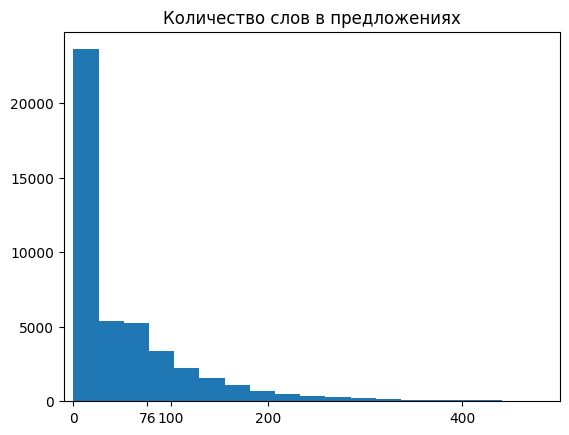

In [15]:
corp = del_stopwords(train.lemma.tolist())
sentence_length = [len(i) for i in corp]

plt.hist(sentence_length, bins=50)
plt.title('Количество слов в предложениях')

ax = plt.gca()
ax.set_xticks([0, 76, 100, 200, 400])
plt.xlim(-10, 500)

In [16]:
print('Минимальное значение', np.min(sentence_length))
print('Максимальное значение', np.max(sentence_length))
print('Медиана', np.median(sentence_length))
print('Среднее', np.average(sentence_length))
print('75 процентилей', np.percentile(sentence_length, 75))
print('96 процентилей', np.percentile(sentence_length, 96))

Минимальное значение 0
Максимальное значение 1296
Медиана 21.0
Среднее 54.89532578527688
75 процентилей 76.0
96 процентилей 224.11999999999534


## Преобразование слов в индексы

In [17]:
padding = '__pad__'

In [18]:
all_words = ' '.join(X_train)
unique_words = set([padding] + all_words.split(' '))
word_dict = {value: key for key, value in enumerate(unique_words)}

In [19]:
len(word_dict), word_dict[padding]

(66018, 14613)

In [20]:
word_dict

{'': 0,
 'банкет': 1,
 'терм': 2,
 'християнка': 3,
 'череп': 4,
 'логопедическая': 5,
 'опросник': 6,
 'этотзанятие': 7,
 'злание': 8,
 'патриатический': 9,
 'опустошение': 10,
 'ордер': 11,
 'эпизод': 12,
 'доуниверситетский': 13,
 'сохранить': 14,
 'виндовса': 15,
 'юморист': 16,
 'географичка': 17,
 'состоятельный': 18,
 'задевали': 19,
 'жлобы': 20,
 'весело': 21,
 'заведнее': 22,
 'пробейте': 23,
 'магический': 24,
 'извнуть': 25,
 'дочурка': 26,
 'притаиться': 27,
 'хайвэй': 28,
 'агрообразовательный': 29,
 'обволакивать': 30,
 'неудаленный': 31,
 'опозорят': 32,
 'доехать': 33,
 'решиться': 34,
 'орднунг': 35,
 'строение': 36,
 'география': 37,
 'транспортировка': 38,
 'валиди': 39,
 'гипермаркет': 40,
 'слабо': 41,
 'фотовыставкитипичный': 42,
 'восстановится': 43,
 'выучивать': 44,
 'ушибить': 45,
 'энерджайзер': 46,
 'шестилетний': 47,
 'краеугольный': 48,
 'байдаг': 49,
 'приготавливались': 50,
 'пальма': 51,
 'гандон': 52,
 'должность': 53,
 'жесткость': 54,
 'скатившись':

In [21]:
def word2num(word_dict, texts, max_len, pad_idx):
    result = []

    for text in texts:
        tmp = []
        for i in range(max_len):
            if len(text) > i and text[i] in word_dict:
                word = text[i]
                tmp.append(word_dict[word])
            else:
                tmp.append(pad_idx)
        result.append(tmp)
    return result

In [22]:
train = word2num(word_dict, X_train, 80, word_dict[padding])
len(train)

45398

In [23]:
test = word2num(word_dict, X_test, 80, word_dict[padding])
len(test)

5960

### Балансировка классов

In [29]:
train_pre = [np.argmax(i) for i in y_train]

unique, counts = np.unique(train_pre, return_counts=True)
print(unique, counts)
counts = [i/len(train_pre) for i in counts]
class_weights = np.array(counts)
print(class_weights)

[0 1] [14601 30797]
[0.3216221 0.6783779]


In [31]:
weight = torch.FloatTensor(class_weights)
weight = weight.to(device)

## Создание моделей

In [24]:
class SentimentCNN(nn.Module):
    def __init__(self, vocab_len, dim, max_len, padding_idx):
        super(SentimentCNN, self).__init__()
        self.max_len = max_len
        self.dim = dim
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(vocab_len, dim, padding_idx=padding_idx)
        
        self.conv1 = nn.Conv2d(1, 16, (2, 2), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=1)
        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(16000, 2) 
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        x = x.reshape(len(x), 1, self.max_len)
        x = self.embedding(x)
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.drop(x)
        x = self.fc1(x)

        x = self.softmax(x)
        return x

In [33]:
max_len=80

cnn = SentimentCNN(len(word_dict), 100, max_len, word_dict[padding])
cnn = cnn.to(device)
loss_fn = nn.BCELoss(weight = weight)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
cnn

SentimentCNN(
  (embedding): Embedding(66018, 100, padding_idx=14613)
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=16000, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [34]:
batch_size = 10

train = TensorDataset(torch.IntTensor(train), torch.FloatTensor(y_train.toarray()))
test = TensorDataset(torch.IntTensor(test), torch.FloatTensor(y_test.toarray()))

train_loader = DataLoader(train,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

## Метрики

In [35]:
metrics_dict_train = {}
metrics_dict_test = {}

In [36]:
def metrics_(model, data_loader, device, epoch, is_train=False):
    correct = 0

    pred = []
    target = []
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)

            pred.extend(outputs.cpu())
            target.extend(y.cpu())


        pred_bin = [i.argmax() for i in pred]
        label_bin = [i.argmax() for i in target]
        
        f1_score = metrics.f1_score(pred_bin, label_bin, average='weighted') #.accuracy_score(predicted, label)
        precision = metrics.precision_score(pred_bin, label_bin, average='weighted')
        recall = metrics.recall_score(pred_bin, label_bin, average='weighted')
        accuracy = metrics.accuracy_score(pred_bin, label_bin)

        tmp_metrics = {'f1-score': f1_score, 'precision': precision, 'recall': recall, 'accuracy': accuracy}
        if is_train:
            metrics_dict_train[epoch] = tmp_metrics
        else:
            metrics_dict_test[epoch] = tmp_metrics

        print('F1-мера:',str('{:04.2f}'.format(f1_score*100))+'%')
        print('Precision:',str('{:04.2f}'.format(precision*100))+'%')
        print('Recall:',str('{:04.2f}'.format(recall*100))+'%')
        print('Accuracy:',str('{:04.2f}'.format(accuracy*100))+'%')

In [37]:
def train_model(model, epochs = 10, prefix='e'):
    start = time.time()
    global metrics_dict_train, metrics_dict_test
    metrics_dict_train = {}
    metrics_dict_test = {}
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            text, labels = data
            text = text.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(text)
            # print(outputs, labels)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # torch.save(model, f'models/{prefix}{epoch}_lstm.pt')
    
        with torch.set_grad_enabled(False):
            print(f'Epoch: {epoch}')
            print('Train')
            metrics_(model, train_loader, device, epoch, is_train=True)
            print('Test')
            metrics_(model, test_loader, device, epoch)

        
    print(f'Total time: {(time.time() - start)/60:.2f} min')

In [39]:
def draw_metrics():
    fig, ax = plt.subplots(2, 2)
    fig.suptitle('Метрики')
    fig.set_size_inches(15, 7)
    
    amount = len(metrics_dict_train)
    
    for i, name in enumerate(['accuracy', 'precision', 'recall', 'f1-score']):
        train_metrics = [metrics_dict_train[i][name] for i in range(amount)]
        test_metrics = [metrics_dict_test[i][name] for i in range(amount)]
    
        x = list(range(amount))
        current_ax = ax[i%2][i//2]
        current_ax.plot(x, train_metrics, label='Train')
        current_ax.plot(x, test_metrics, label='Test')
        current_ax.set_title(name)
        current_ax.legend(loc='upper left')
        current_ax.grid()

In [38]:
train_model(cnn, epochs = 10)

100%|██████████████████████████████████████| 4540/4540 [00:28<00:00, 161.78it/s]


Epoch: 0
Train
F1-мера: 74.55%
Precision: 82.73%
Recall: 70.31%
Accuracy: 70.31%
Test
F1-мера: 60.84%
Precision: 76.52%
Recall: 55.69%
Accuracy: 55.69%


100%|██████████████████████████████████████| 4540/4540 [00:26<00:00, 170.89it/s]


Epoch: 1
Train
F1-мера: 75.52%
Precision: 83.12%
Recall: 71.75%
Accuracy: 71.75%
Test
F1-мера: 61.55%
Precision: 76.55%
Recall: 56.83%
Accuracy: 56.83%


100%|██████████████████████████████████████| 4540/4540 [00:26<00:00, 171.40it/s]


Epoch: 2
Train
F1-мера: 76.04%
Precision: 83.00%
Recall: 72.68%
Accuracy: 72.68%
Test
F1-мера: 62.52%
Precision: 76.79%
Recall: 58.26%
Accuracy: 58.26%


100%|██████████████████████████████████████| 4540/4540 [00:26<00:00, 171.59it/s]


Epoch: 3
Train
F1-мера: 76.70%
Precision: 82.93%
Recall: 73.79%
Accuracy: 73.79%
Test
F1-мера: 63.02%
Precision: 75.23%
Recall: 59.58%
Accuracy: 59.58%


100%|██████████████████████████████████████| 4540/4540 [00:26<00:00, 171.12it/s]


Epoch: 4
Train
F1-мера: 77.28%
Precision: 83.62%
Recall: 74.38%
Accuracy: 74.38%
Test
F1-мера: 63.05%
Precision: 75.79%
Recall: 59.43%
Accuracy: 59.43%


100%|██████████████████████████████████████| 4540/4540 [00:26<00:00, 170.89it/s]


Epoch: 5
Train
F1-мера: 77.25%
Precision: 80.46%
Recall: 75.72%
Accuracy: 75.72%
Test
F1-мера: 62.95%
Precision: 71.05%
Recall: 60.84%
Accuracy: 60.84%


100%|██████████████████████████████████████| 4540/4540 [00:27<00:00, 165.12it/s]


Epoch: 6
Train
F1-мера: 77.46%
Precision: 79.59%
Recall: 76.38%
Accuracy: 76.38%
Test
F1-мера: 63.47%
Precision: 69.51%
Recall: 61.98%
Accuracy: 61.98%


100%|██████████████████████████████████████| 4540/4540 [00:27<00:00, 164.86it/s]


Epoch: 7
Train
F1-мера: 78.24%
Precision: 81.52%
Recall: 76.74%
Accuracy: 76.74%
Test
F1-мера: 62.92%
Precision: 71.46%
Recall: 60.67%
Accuracy: 60.67%


100%|██████████████████████████████████████| 4540/4540 [00:27<00:00, 163.26it/s]


Epoch: 8
Train
F1-мера: 78.15%
Precision: 79.58%
Recall: 77.39%
Accuracy: 77.39%
Test
F1-мера: 63.73%
Precision: 68.39%
Recall: 62.62%
Accuracy: 62.62%


100%|██████████████████████████████████████| 4540/4540 [00:27<00:00, 167.44it/s]


Epoch: 9
Train
F1-мера: 78.79%
Precision: 80.91%
Recall: 77.77%
Accuracy: 77.77%
Test
F1-мера: 63.13%
Precision: 69.60%
Recall: 61.51%
Accuracy: 61.51%
Total time: 6.39 min


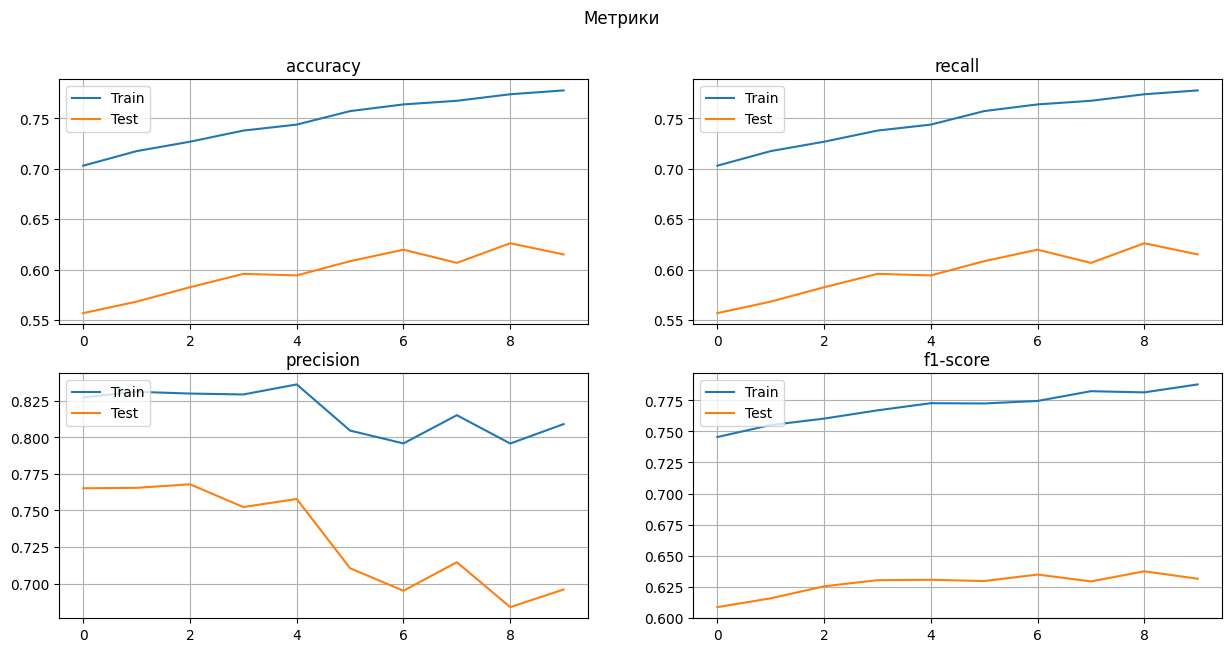

In [40]:
draw_metrics()

## Используем предобученную word2vec модель в качестве embedding